In [1]:
import numpy as np
import pandas as pd
import cv2, os, glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add, Concatenate, Conv2D,
    Input, Lambda, LeakyReLU,
    MaxPool2D, UpSampling2D, ZeroPadding2D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)


2025-04-24 16:49:19.845221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]
yolo_anchors = np.array([
    (10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
    (59, 119), (116, 90), (156, 198), (373, 326)],
    np.float32) / 416

yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

class_names = [
    'person', 'bicycle','car','motorbike','aeroplane','bus','train','truck','boat',
    'traffic light','fire hydrant','stop sign','parking meter','bench',
    'bird','cat','dog','horse','sheep','cow','elephant','bear','zebra',
    'giraffe','backpack','umbrella','handbag','tie','suitcase','frisbee',
    'skis','snowboard','sports ball','kite','baseball bat','baseball glove',
    'skateboard','surfboard','tennis racket','bottle','wine glass','cup',
    'fork','knife','spoon','bowl','banana','apple','sandwich','orange',
    'broccoli','carrot','hot dog','pizza','donut','cake','chair','sofa',
    'pottedplant','bed','diningtable','toilet','tvmonitor','laptop','mouse',
    'remote','keyboard','cell phone','microwave','oven','toaster','sink',
    'refrigerator','book','clock','vase','scissors','teddy bear',
    'hair drier','toothbrush'
]

def load_darknet_weights(model, weights_file):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
    
    layers = YOLOV3_LAYER_LIST  # List of layers as defined in your code
    
    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]
            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input.shape[-1]  # Use layer.input.shape for input dimension
            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                bn_weights = np.fromfile(wf, dtype=np.float32, count=4 * filters)
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
                
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
            conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])
            
            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)
    
    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()

def broadcast_iou(box_1, box_2):
   
    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)
    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) - tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) - tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)
  
def freeze_all(model, frozen = True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img

def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train 

@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):
    N = tf.shape(y_true)[0]
    y_true_out = tf.zeros(
        (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))
    anchor_idxs = tf.cast(anchor_idxs, tf.int32)
    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))
            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2
                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)
                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1
    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())

def transform_targets(y_train, anchors, anchor_masks, classes):
    y_outs = []
    grid_size = 13
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2), (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)
    y_train = tf.concat([y_train, anchor_idx], axis=-1)
    for anchor_idxs in anchor_masks:
        y_outs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs, classes))
        grid_size *= 2
    return tuple(y_outs)   

class BatchNormalization(tf.keras.layers.BatchNormalization):
    @tf.function
    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super(BatchNormalization, self).call(x, training=training)

def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

def DarknetResidual(x, filters):
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])  # Ensure addition is valid
    return x  # Return the tensor

def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)  # Ensure residual connection
    return x  # Return the tensor

def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)
  
def YoloConv(x_in, filters, name=None):
    if isinstance(x_in, tuple):
        inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
        x, x_skip = inputs
        # concat with skip connection
        x = DarknetConv(x, filters, 1)
        x = UpSampling2D(2)(x)
        x = Concatenate()([x, x_skip])
    else:
        x = inputs = Input(x_in.shape[1:])
    x = DarknetConv(x, filters, 1)
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, filters, 1)
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, filters, 1)
    return Model(inputs, x, name=name)(x_in)
  
def YoloOutput(x_in, filters, anchors, classes, name=None):
    x = inputs = Input(x_in.shape[1:])
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
    x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], anchors, classes + 5)))(x)
    return tf.keras.Model(inputs, x, name=name)(x_in)
  
def yolo_boxes(pred, anchors, classes):
    '''pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))'''
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)
    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors
    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)
    return bbox, objectness, class_probs, pred_box
  
def yolo_nms(outputs, anchors, masks, classes):
    '''boxes, conf, type'''
    b, c, t = [], [], []
    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))
    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)
    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores,
            (tf.shape(scores)[0], -1, tf.shape(scores)[-1])
        ),
        max_output_size_per_class=100,
        max_total_size = 100,
        iou_threshold = 0.5,
        score_threshold = 0.5
    )
    return boxes, scores, classes, valid_detections
  
def YoloV3(size=None, channels=3, anchors=yolo_anchors, masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels])
    x_36, x_61, x = Darknet(name='yolo_darknet')(x)
    x = YoloConv(x, 512, name='yolo_conv_0')
    output_0 = YoloOutput(x, 512, len(masks[0]), classes, name='yolo_output_0')
    x = YoloConv((x, x_61), 256, name='yolo_conv_1')
    output_1 = YoloOutput(x, 256, len(masks[1]), classes, name='yolo_output_1')
    x = YoloConv((x, x_36), 128, name='yolo_conv_2')
    output_2 = YoloOutput(x, 128, len(masks[2]), classes, name='yolo_output_2')
    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')
    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)
    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))
    return Model(inputs, outputs, name='yolov3')
  
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]
        
        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]
        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]
        
        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh), tf.zeros_like(true_wh), true_wh)
        
        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))
        best_iou = tf.reduce_max(broadcast_iou(
            pred_box, true_box_flat), axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)
        
        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        # Could also use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)
        
        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))
        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss
  
yolo = YoloV3(size=416, classes=80)
yolo.summary()

2025-04-24 16:50:08.804268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "yolov3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 yolo_darknet (Functional)      ((None, None, None,  40620640    ['input_1[0][0]']                
                                 256),                                                            
                                 (None, None, None,                                               
                                 512),                                                            
                                 (None, None, None,                                          

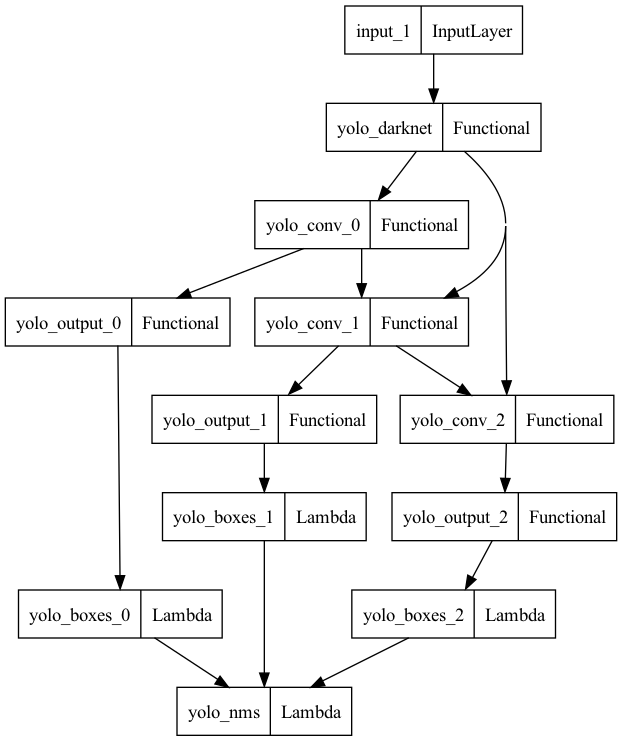

In [3]:
from tensorflow.keras.utils import plot_model

plot_model(
    yolo, rankdir = 'TB',
    to_file = 'yolo_model1.png',
    show_shapes = False,
    show_layer_names = True,
    expand_nested = False
)

In [6]:
load_darknet_weights(yolo, 'yolov3.weights')

def predict(image_file, visualize = True, figsize = (16, 16)):
    img = tf.image.decode_image(open(image_file, 'rb').read(), channels=3)
    img = tf.expand_dims(img, 0)
    img = transform_images(img, 416)
    boxes, scores, classes, nums = yolo.predict(img)
    img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    if visualize:
        fig, axes = plt.subplots(figsize = figsize)
        plt.imshow(img)
        plt.show()
    return boxes, scores, classes, nums

In [8]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Updated prediction function with scaled bounding boxes
def predict(image_file, visualize=True, figsize=(16, 16)):
    # Load and preprocess the image
    img = tf.image.decode_image(open(image_file, 'rb').read(), channels=3)
    img = tf.expand_dims(img, 0)
    img = transform_images(img, 416)
    
    # Get predictions
    boxes, scores, classes, nums = yolo.predict(img)
    
    # Convert the original image for plotting
    img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
    img_height, img_width, _ = img.shape
    
    # Plotting the results with scaled boxes
    if visualize:
        plt.figure(figsize=figsize)
        
        for i in range(nums[0]):
            # Extract and scale box coordinates to pixel values
            y1, x1, y2, x2 = boxes[0][i]
            x1 = int(x1 * img_width)
            y1 = int(y1 * img_height)
            x2 = int(x2 * img_width)
            y2 = int(y2 * img_height)
            
            # Draw bounding box
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            
            # Prepare label with class and score
            class_name = class_names[int(classes[0][i])]
            score = scores[0][i]
            label = f"{class_name}: {score:.2f}"
            
            # Display label above the box
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        
        # Show the final image with annotations
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    
    return boxes, scores, classes, nums


In [13]:
image_file = 'kangaroo.png'

1/1 [==============================] - 0s 278ms/step


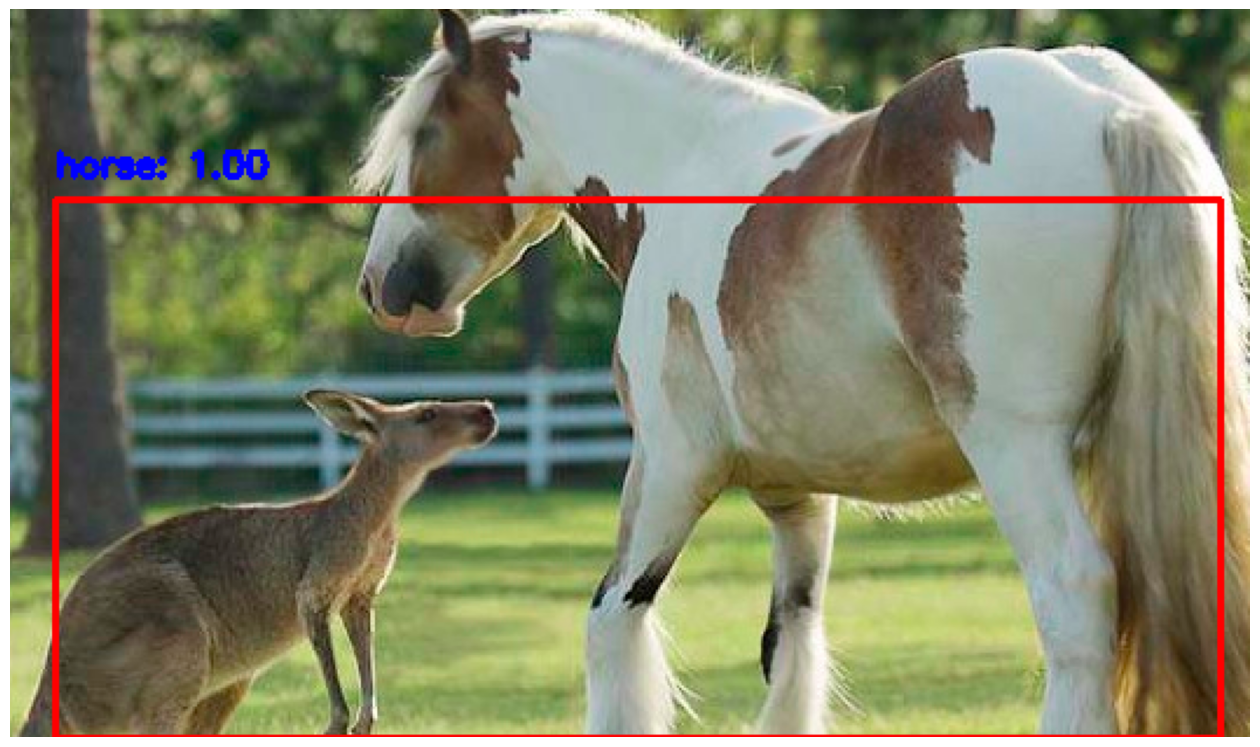

In [16]:
[boxes, scores, classes, nums] =predict(image_file)

1/1 [==============================] - 0s 282ms/step


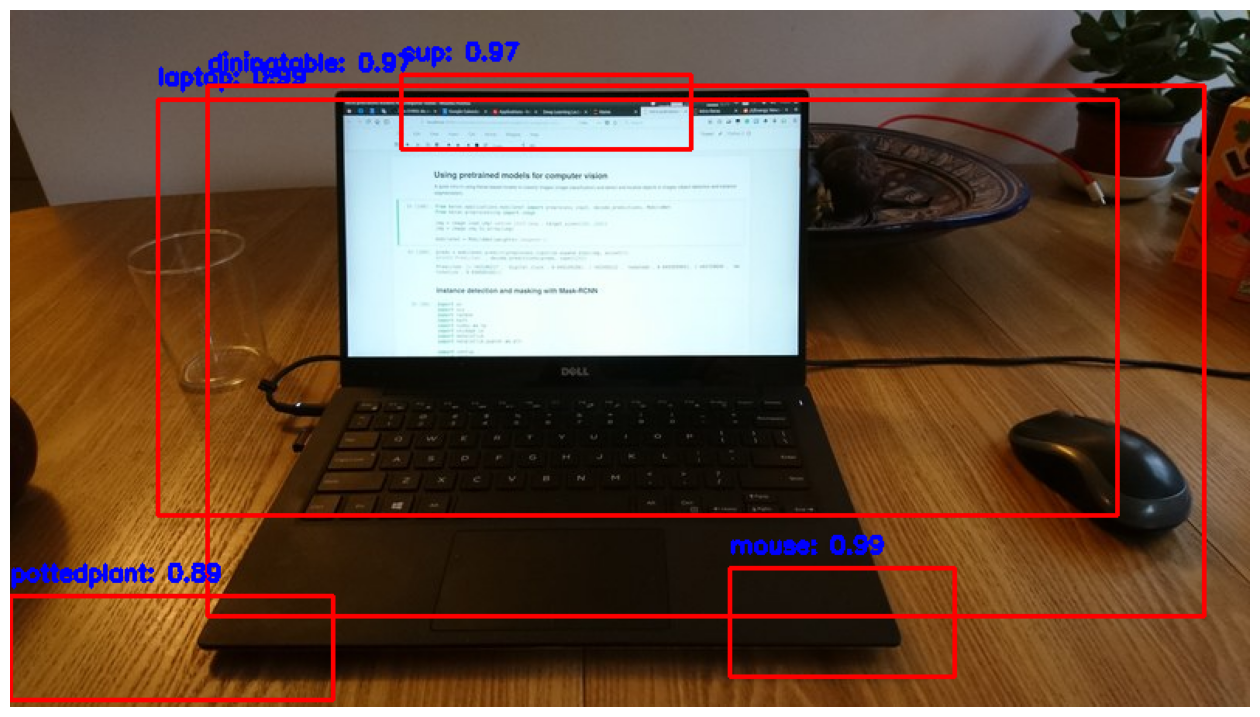

In [17]:
[boxes, scores, classes, nums] = predict('laptop.jpeg')

1/1 [==============================] - 0s 276ms/step


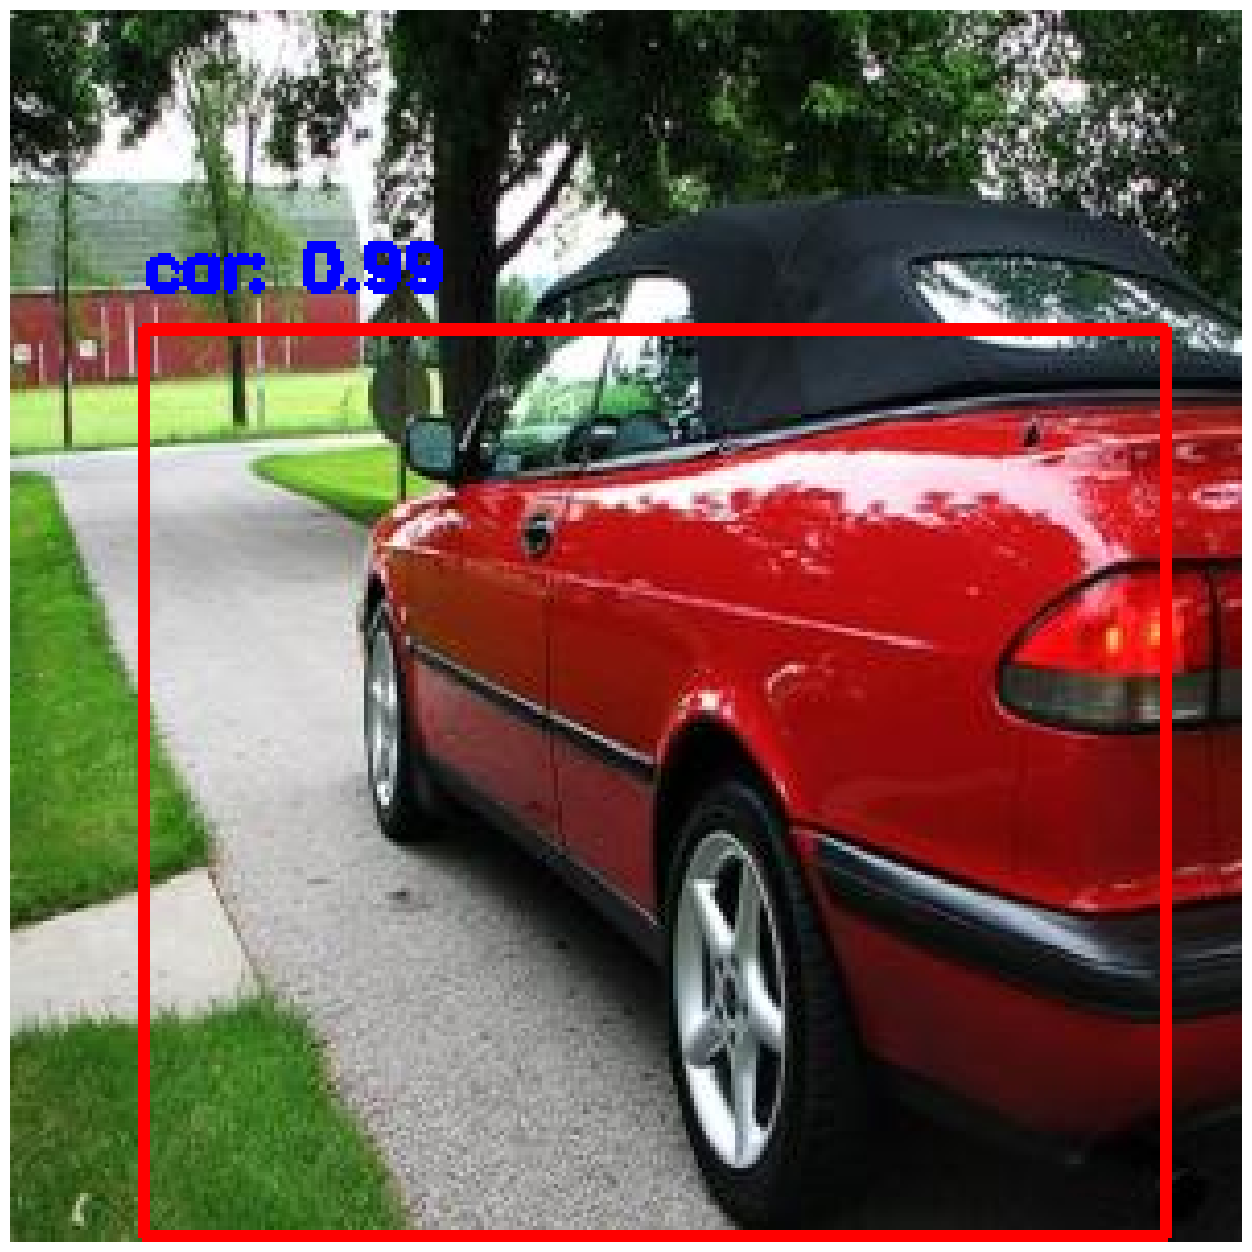

In [19]:
[boxes, scores, classes, nums] = predict('images_resize/000007.jpg')